In [26]:
%matplotlib inline
import matplotlib.pyplot as plt

import math
from scipy.stats import itemfreq, chisquare, kstest, norm, triang
from scipy.misc import comb
import scipy.integrate as integrate
import numpy as np
import sys
sys.path.append('../../prngs-and-permutations/Code/modules')
from sha256prng import SHA256


# Equidistribution tests

## Tests based on binning the PRNs

Let's generate 10^7 PRNs. We'll scale them by 1000 and take the floor -- effectively, we're looking at only the first 3 digits of the PRNs.  Then, we can tally up how many of each occurs and do the chi-squared test and range test on these counts.

In [20]:
ss = 100 # seed value
prng = SHA256(ss)

prns = [prng.random() for i in range(10**7)]

In [21]:
def conductChisqTest(sequence, multiplier=2**10):
    '''
    Given a sequence of U(0,1) values, bin values by scaling by multiplier and taking the floor.
    Then conduct a chi-squared test for uniformity on these categories.
    '''
    
    bins = [int(np.floor(val*multiplier)) for val in sequence]
    res = chisquare(itemfreq(bins)[:,1])
    return(res[1])

conductChisqTest(prns, 2**10)

0.51270388844059278

In [23]:

def distrNormalRange(w, n):
    '''
    The CDF of the range of n IID standard normals evaluated at w
    '''
    innerInt = lambda x: norm.pdf(x)*(norm.cdf(x+w) - norm.cdf(x))**(n-1)
    tmp = integrate.quad(innerInt, -2*w, 2*w)
    if n*tmp[0] > 1:
        return n*(tmp[0] - tmp[1])
    else:
        return n*tmp[0]

def distrMultinomialRange(w, n, k):
    '''
    CDF of the range of multinomial variables, evaluated at w
    n draws, k categories each having probability 1/k
    '''
    cutoff = (w - 1/(2*n))*np.sqrt(k/n)
    return distrNormalRange(cutoff, k)

def conductRangeTest(sequence, multiplier=2**10):
    bins = [int(np.floor(val*multiplier)) for val in sequence]
    counts = itemfreq(bins)[:,1]
    return 1 - distrMultinomialRange(np.ptp(counts), np.sum(counts), len(counts))

conductRangeTest(prns)

0.09078101173369801

Let's do the same thing for the randint method:

In [24]:
ss = 100 # seed value
prng = SHA256(ss)

prns = [prng.randint(1, 21) for i in range(10**7)]
print("Chi-squared test:" + str(conductChisqTest(prns, multiplier = 1)))
print("Range test: " + str(conductRangeTest(prns, multiplier = 1)))

Chi-squared test:0.89855453013
Range test: 0.8910682080071386


And we'll do it again, taking modulus instead of floor:

In [25]:
ss = 100 # seed value
prng = SHA256(ss)

prns = [int(prng.nextRandom() % 13) for i in range(10**7)]
print("Chi-squared test:" + str(conductChisqTest(prns, multiplier = 1)))
print("Range test: " + str(conductRangeTest(prns, multiplier = 1)))

Chi-squared test:0.480790370691
Range test: 0.6811907587409376


## Kolmogorov-Smirnov test

In [11]:
ss = 100 # seed value
prng = SHA256(ss)

prns = prng.random(10**7)

In [12]:
kstest(prns, 'uniform')

KstestResult(statistic=0.00044107848612390255, pvalue=0.04084928509400116)

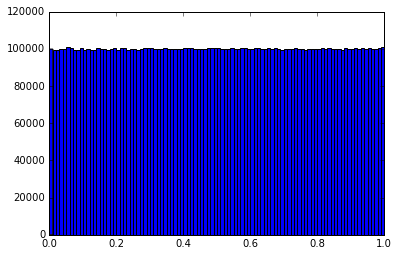

In [13]:
plt.hist(prns, bins = 100)
plt.show()

Let's do a KS test for the difference between consecutive PRNs.  If, under the null, they are IID uniform(0,1), then the differences between consecutive values should be IID triangular with distribution

$$\mathbb{P}(U_1 - U_2 \leq y) = -\frac{sign(y)}{2}y^2 + y + \frac{1}{2}$$

In [14]:
first_differences = prns[1:] - prns[:len(prns)-1]
kstest(first_differences, lambda x: triang.cdf(x, c = 0.5, loc = -1, scale = 2))

KstestResult(statistic=0.00022022401190403829, pvalue=0.7172039453555028)

# Serial tests

We'll use a chi-squared test to count how often pairs of integers occur.

In [15]:
ss = 100 # seed value
prng = SHA256(ss)

bin_counts = [str(np.floor(prng.random()*100)) + "," + str(np.floor(prng.random()*100)) for i in range(int(10**7/2))]

In [16]:
print(bin_counts[:5])
bin_counts = itemfreq(bin_counts)
chisquare(bin_counts[:,1].astype('int'))

['20.0,90.0', '93.0,43.0', '84.0,74.0', '76.0,62.0', '67.0,3.0']


Power_divergenceResult(statistic=10152.828, pvalue=0.13852676704983599)

# Gap test

For values $\alpha < \beta$, we say that a gap of length $r$ occurs when $U_j$ and $U_{j+r-1}$ lie in the interval $(\alpha,\beta)$ but $U_{j+1}, \dots, U_{j + r - 2}$ do not. We want to count the number of gaps of size $0$, $1,$ up to size $t$ for some reasonable value.

This is slightly different from Knuth's version.  He proposes generating random numbers until $n$ gaps are observed.  Instead, I will fix the sequence length and count how many gaps occur.  Then I'll condition on that number of gaps (same as the number of items in the range $(\alpha, \beta)$) to generate expected counts for each gap length.

In [17]:
def gap_test(sequence, alpha, beta, t):
    '''
    inputs:
    sequence = sequence of numbers between 0 and 1
    alpha    = lower limit of interval
    beta     = upper limit of interval
    t        = max gap size (anything with gap larger than t will fall in the last category)
    '''
    # check
    assert alpha >= 0
    assert beta <= 1
    assert alpha < beta
    
    # initialize
    count = [0 for r in range(t+1)]
    r = 0
    n = len(sequence)
    
    # count gaps of size 0, 1, ..., >=t
    for j in range(n):
        if sequence[j] >= alpha and sequence[j] < beta:
            if r >= t:
                count[t] += 1
            else:
                count[r] += 1
            r = 0
        else:
            r += 1
            
    # conduct chi-square test
    p = beta-alpha
    conditional_n = sum(count)
    expected = [conditional_n*p*(1-p)**power for power in range(t)]
    expected.append(conditional_n*(1-p)**t)
    return {'observed' :  count,
            'expected' : expected,
            'chisquare' : chisquare(count, expected)}

In [18]:
ss = 100 # seed value
prng = SHA256(ss)

prns = prng.random(10**7)
gap_test(prns, 0.25, 0.75, 5)

{'chisquare': Power_divergenceResult(statistic=9.0369556501017989, pvalue=0.10759916937143836),
 'expected': [2501539.0,
  1250769.5,
  625384.75,
  312692.375,
  156346.1875,
  156346.1875],
 'observed': [2503061, 1250943, 624622, 312060, 156857, 155535]}

# Coupon collector's test

This test analyzes the number $r$ of items in the sequence $Y_j, Y_{j+1}, \dots, Y_{j+r}$ (where $Y_j = \lfloor d U_j \rfloor$) to obtain all each of the integers $\{0, 1, \dots, d-1\}$ at least once.

In [33]:
def coupontest(sequence, d, t):
    '''
    Given a sequence of U(0,1) values, converts to integer values on {0, 1, ..., d-1}
    and tests the length of 'runs' needed to hit each integer at least once.
    The max run length considered is t.
    '''

    assert t >= d
    
    # convert to integer PRNs
    sequence = [int(np.floor(d*val)) for val in sequence]
    
    # initialize
    count = [0 for i in range(t+1)]
    occurs = [0 for k in range(d)]
    q = 0
    r = 0
    n = len(sequence)
    
    for j in range(n):
        r += 1
        if occurs[sequence[j]] == 0:
            occurs[sequence[j]] = 1
            q += 1
            if q == d:
                if r >= t:
                    count[t] += 1
                else:
                    count[r] += 1
                q = 0
                r = 0
                occurs = [0 for k in range(d)]
        j += 1
        
    expected = [0 for i in range(t+1)]
    conditional_n = sum(count)
    expected[d:t] = [conditional_n*comb(r-1, d-1)*math.factorial(d)/d**r for r in range(d, t)]
    expected[t] = conditional_n - sum(expected)
    return {'observed' :  count,
            'expected' : expected,
            'chisquare' : chisquare(count, expected)}    




ss = 100 # seed value
prng = SHA256(ss)

prns = [prng.random() for i in range(10**7)]
coupontest(prns, d=5, t=10) 
    

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/scipy/stats/stats.py:4350: RuntimeWarning: invalid value encountered in true_divide
  terms = (f_obs - f_exp)**2 / f_exp


{'chisquare': Power_divergenceResult(statistic=nan, pvalue=nan),
 'expected': [0,
  0,
  0,
  0,
  0,
  33622.963199999998,
  33622.963199999998,
  20173.77792,
  9414.4296959999992,
  3765.7718783999999,
  774998.09410560003],
 'observed': [0, 0, 0, 0, 0, 33842, 67151, 87353, 93973, 91474, 501805]}

# Permutation test

This test looks at orderings of $t$-tuples $(U_{jt}, U_{jt + 1}, \dots, U_{jt + t - 1})$ for $0 \leq j < t$. In each tuple, there are $t!$ possible orderings.

In [38]:
def conductPermTest(sequence, tuplelen):
    '''
    Break sequence into tuples of length tuplelen. Find the ordering of each tuple, and do a chi-squared test.
    Under the null, each ordering has equal probability.
    '''
    
    nperms = np.floor(len(sequence)/tuplelen)
    counts = dict()
    
    for j in range(int(nperms)):
        f = str(np.argsort(sequence[(j*tuplelen):(j*tuplelen + tuplelen )]))
        if f in counts.keys():
            counts[f] += 1
        else:
            counts[f] = 1
    return chisquare(list(counts.values()))[1]

conductPermTest(prns[:10**5], 3)

0.89018642575361739

In [39]:
conductPermTest(prns[:10**5], 5)

0.88118850215850031